# 🚀 Spaceship Titanic

Dieses Repository/Notebook enthält eine **kompakte, deutsch kommentierte Lösung** für den Kaggle-Wettbewerb *Spaceship Titanic*.
Ziel ist es, vorherzusagen, ob ein Passagier **transportiert** wurde (`Transported` ∈ {True, False}).

## 📌 Inhalt / Aufbau

1. **Mini‑EDA (kurz & deutsch)**
   - Größe & Zielverteilung (Transportiert‑Rate)
   - Fehlenden‑Werte‑Übersicht (Missingno) in **Orange/Schwarz**
   - Verteilungen numerischer Variablen (mit `log1p` für schiefe Ausgaben)
   - Kategorische Verteilungen + Transportiert‑Quote
   - Korrelationen (numerisch)

2. **Feature Engineering (kurz & Kaggle‑ready)**
   - `Cabin` → **Deck / CabinNum / Side**
   - `PassengerId` → **GroupId / GroupSize / IsAlone**
   - Ausgaben: **TotalSpend**, **HasSpend**, **log1p**‑Features je Ausgabenkategorie
   - Konsistenz: **SpendWhileCryo** (Ausgaben trotz Kryo‑Schlaf?)
   - **AgeBin** (Kind/Teen/Erwachsen/Mitte/Senior)
   - Imputation: numerisch **Median**, kategorisch **'Unknown'**
   - 👉 **Spaltennamen bleiben Englisch** wie im Kaggle‑Datensatz (Kompatibilität)

3. **Modellierung (Pipeline)**
   - **ColumnTransformer**: One‑Hot für Kategorik, Passthrough für Numerik
   - **RandomForestClassifier** (600 Trees, `random_state=42`)
   - **Stratified 5‑Fold CV**: `cross_val_score` (Accuracy)
   - **OOF‑Konfusionsmatrix** + **Klassifikationsbericht** (leakage‑frei)

4. **Submission**
   - Finales Fit auf allen Trainingsdaten
   - Vorhersagen für Test‑Set
   - Export **`submission.csv`** (`PassengerId`, `Transported`)

## 🧪 Wichtige Features (Kurzliste)

- **Cabin‑Split**: `Deck`, `CabinNum`, `Side`
- **Gruppen**: `GroupId`, `GroupSize`, `IsAlone`
- **Ausgaben**: `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` → `TotalSpend`, `HasSpend`, `*_log1p`
- **Konsistenz**: `SpendWhileCryo`
- **Alter**: `Age`, `AgeBin`

---

## 📊 Evaluation

- **Metrik**: Accuracy (wie im Wettbewerb)
- **Cross‑Validation**: StratifiedKFold (5 Splits, `shuffle=True`, `random_state=42`)
- **OOF‑Konfusionsmatrix** und **Klassifikationsbericht** zeigen reale Generalisierungsleistung.

---

## ⚙️ Abhängigkeiten

- Python ≥ 3.8, `pandas`, `numpy`, `scikit‑learn`, `matplotlib`, `seaborn`
- Optional für Mini‑EDA: `missingno` (`pip install missingno`)

---

## 🔁 Reproduzierbarkeit

- Feste Seeds (`random_state=42`)
- Konsistente CV (5‑Fold, stratified)
- Keine Datenleckage (OOF‑Predictions für Metriken)

---

## 🙌 Credits & Fußnote

**Made with ❤️ by Emr7y** · Kaggle: *Spaceship Titanic* 


# Spaceship Titanic

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import category_encoders as ce
from sklearn.model_selection import StratifiedKFold
import missingno as msno
from sklearn.impute import SimpleImputer

plt.style.use('ggplot')

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

In [3]:

print("Train Shape:", train_df.shape)
print("Test Shape:", test_df.shape)

train_df.head()

Train Shape: (8693, 14)
Test Shape: (4277, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


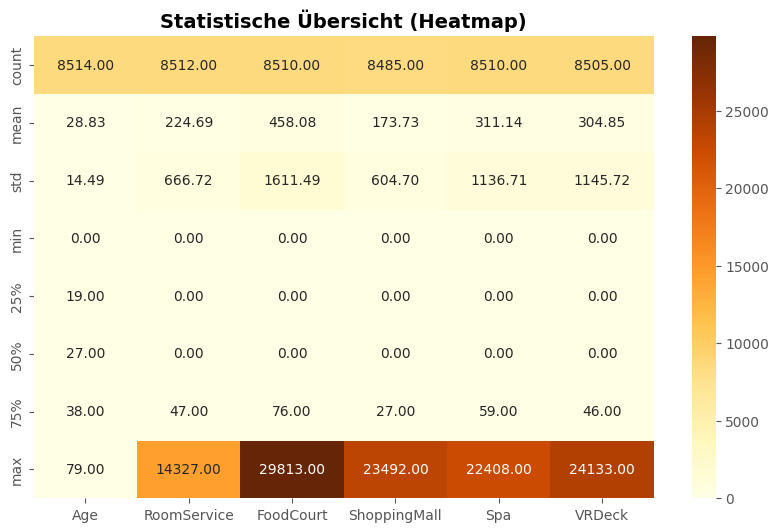

In [5]:
# Statistische Übersicht holen
desc = train_df.describe()

# Heatmap zeichnen
plt.figure(figsize=(10,6))
sns.heatmap(desc, annot=True, fmt=".2f", cmap="YlOrBr")  # Farbschema: Gelb-Orange-Braun
plt.title("Statistische Übersicht (Heatmap)", fontsize=14, fontweight='bold')
plt.show()

Transported
True     4378
False    4315
Name: count, dtype: int64


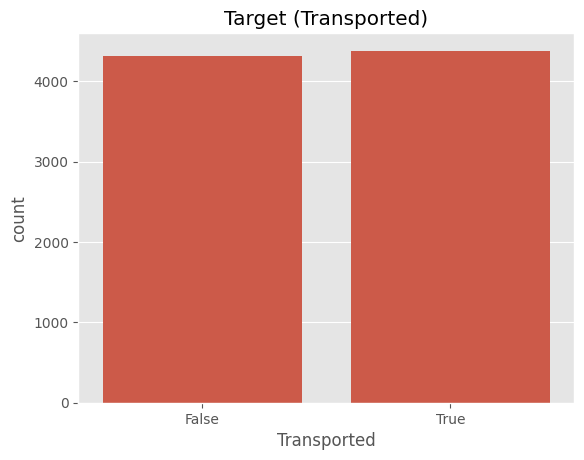

In [6]:
print(train_df["Transported"].value_counts())
sns.countplot(x="Transported", data=train_df)
plt.title("Target (Transported)")
plt.show()

###  EDA

In [7]:
# Fehlende Werte behandeln
missing_values = train_df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_values / len(train_df)) * 100

missing_df = pd.DataFrame({'fehlende Zahlen': missing_values, 'in (%)': missing_percent})
missing_df[missing_df['fehlende Zahlen'] > 0]

,fehlende Zahlen,in (%)
CryoSleep,217,2.496261
ShoppingMall,208,2.392730
VIP,203,2.335212
HomePlanet,201,2.312205
Name,200,2.300702
Cabin,199,2.289198
VRDeck,188,2.162660
FoodCourt,183,2.105142
Spa,183,2.105142
Destination,182,2.093639


In [8]:
#!pip install missingno

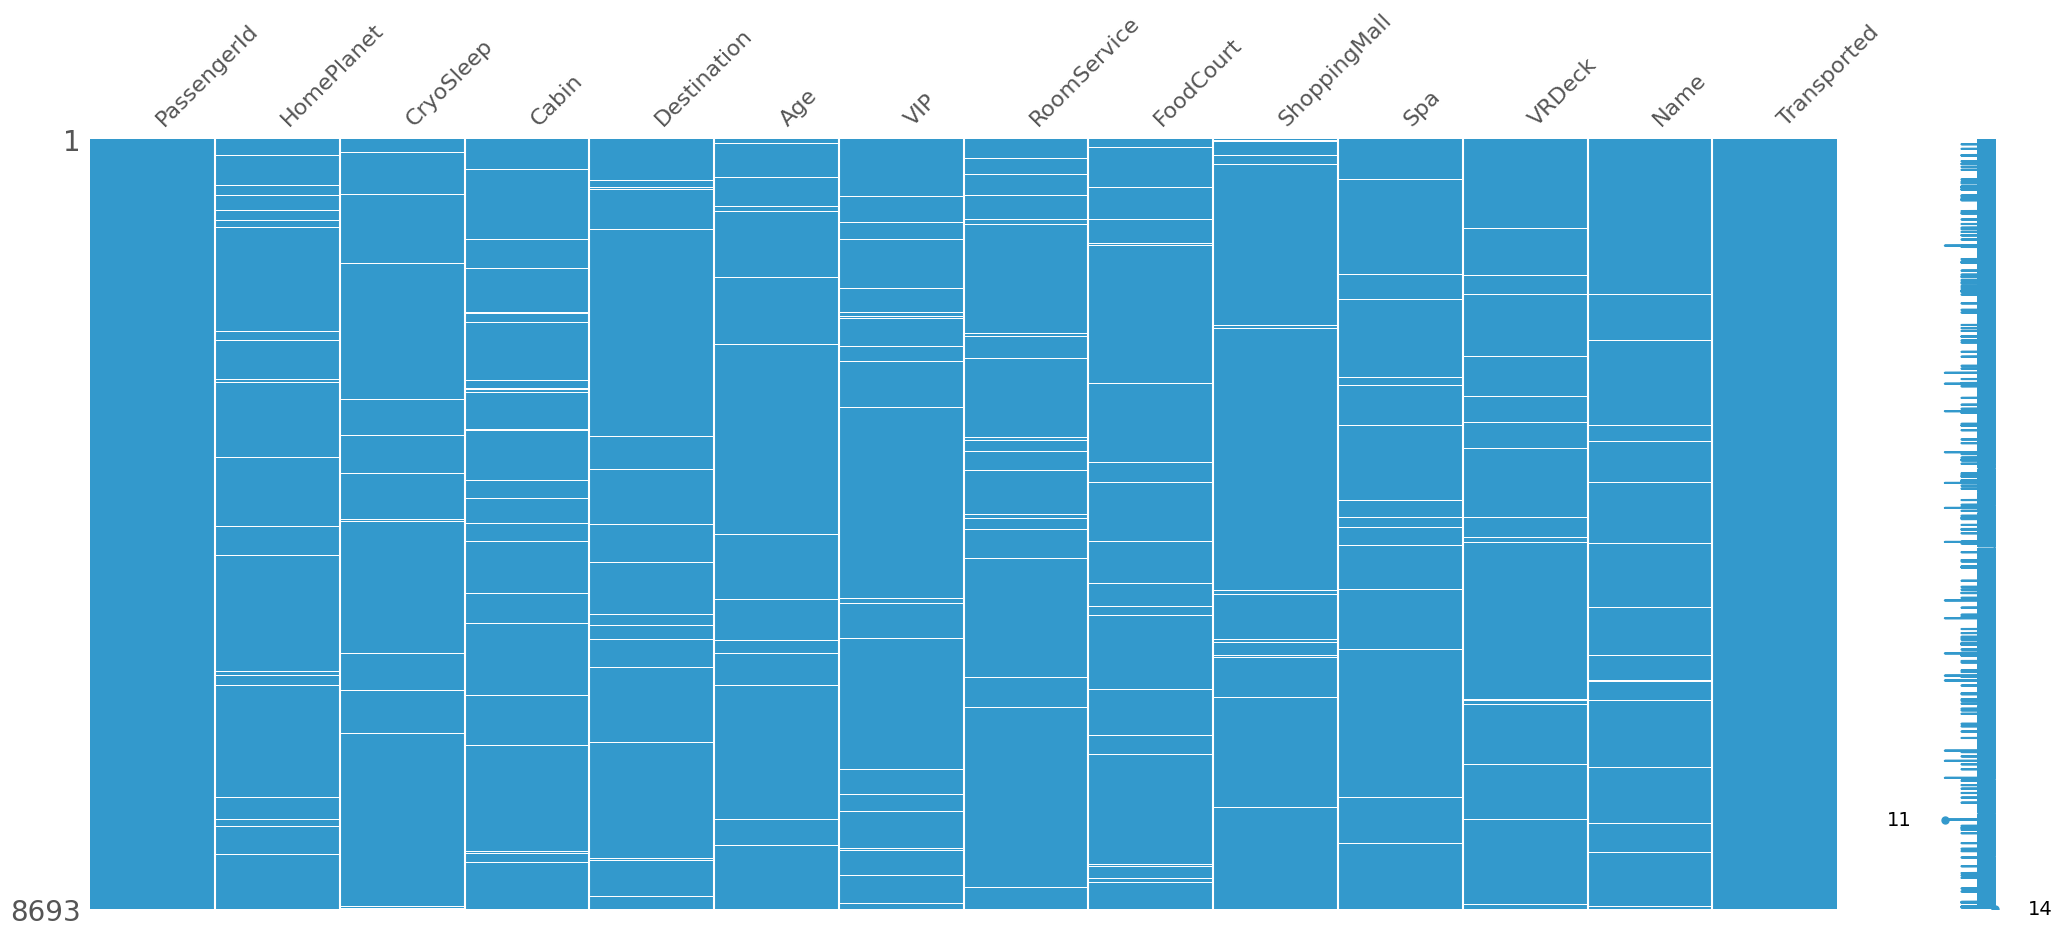

In [9]:
# Fehlende Werte Matrix 
msno.matrix(train_df, color=(0.2, 0.6, 0.8))
plt.show()

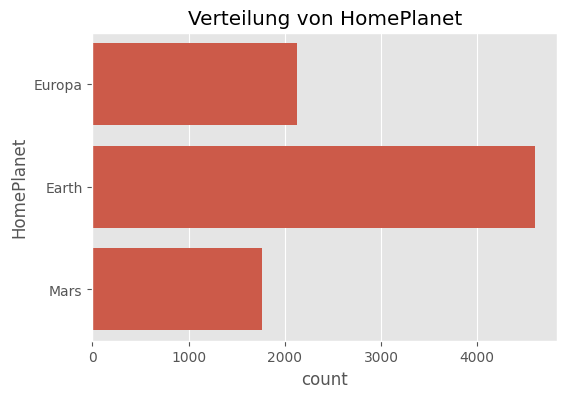

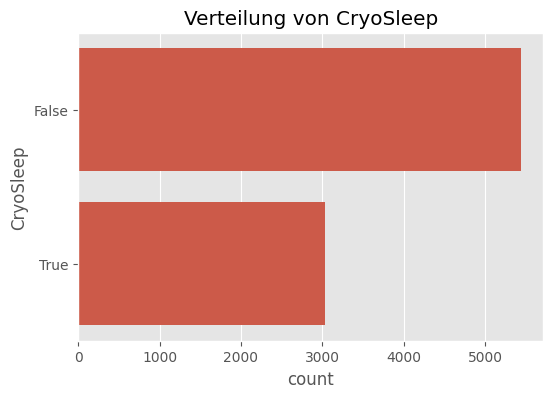

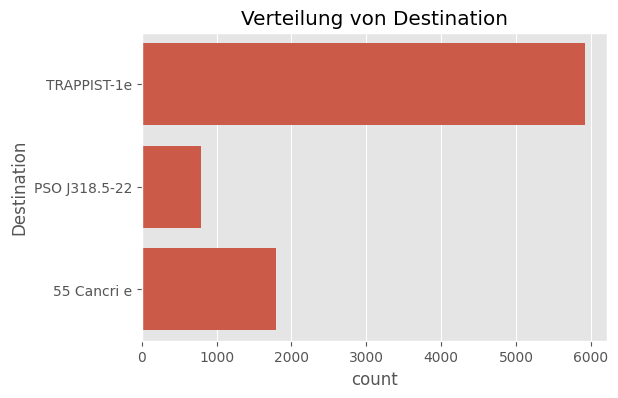

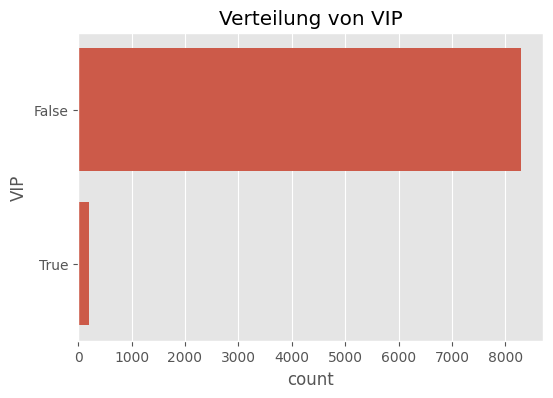

In [10]:
categorical_cols = ['HomePlanet','CryoSleep','Destination','VIP']
for col in categorical_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(y=col, data=train_df)
    plt.title(f"Verteilung von {col}")
    plt.show()

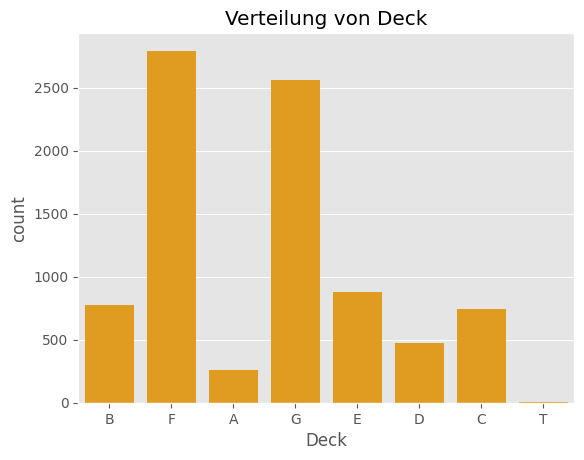

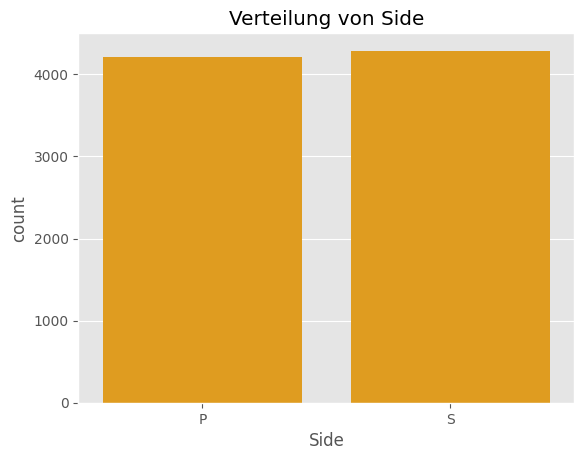

In [11]:
# Cabin separat: nur Deck & Side
train_df[['Deck','Num','Side']] = train_df['Cabin'].str.split('/', expand=True)
for col in ['Deck','Side']:
    sns.countplot(x=col, data=train_df, color="orange")
    plt.title(f"Verteilung von {col}")
    plt.show()

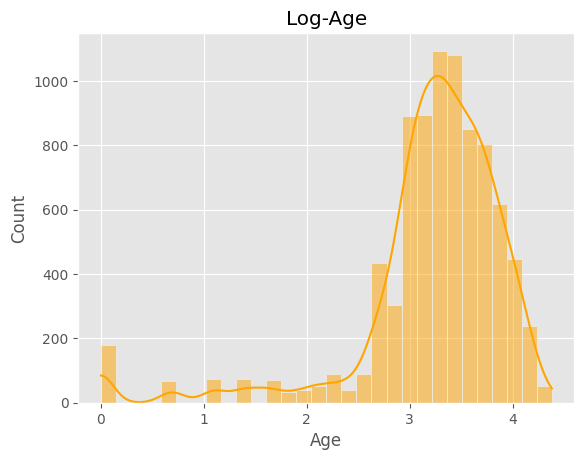

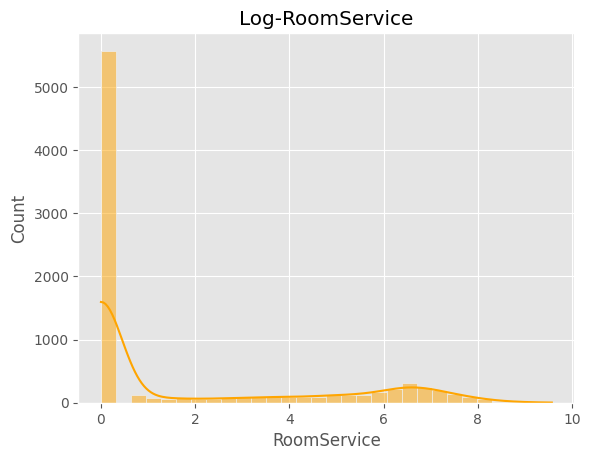

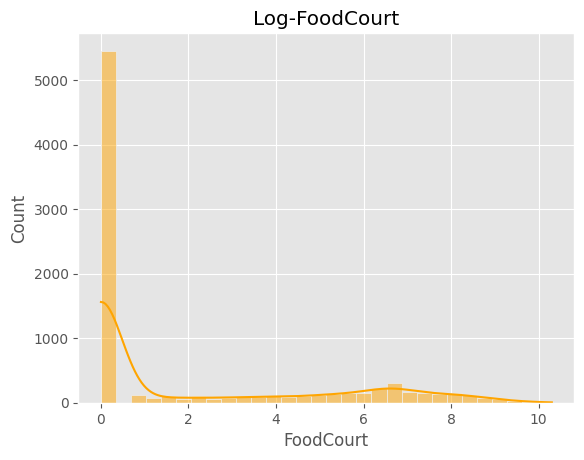

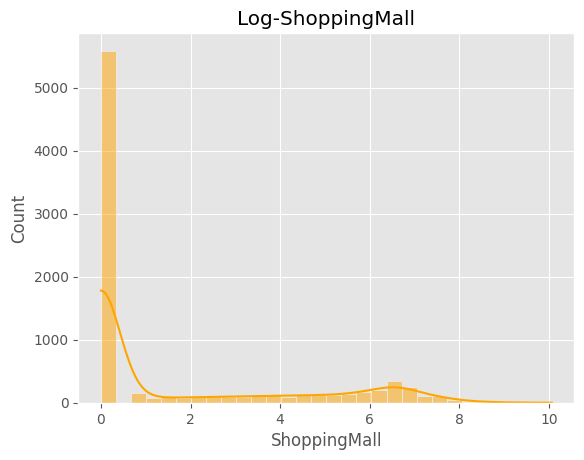

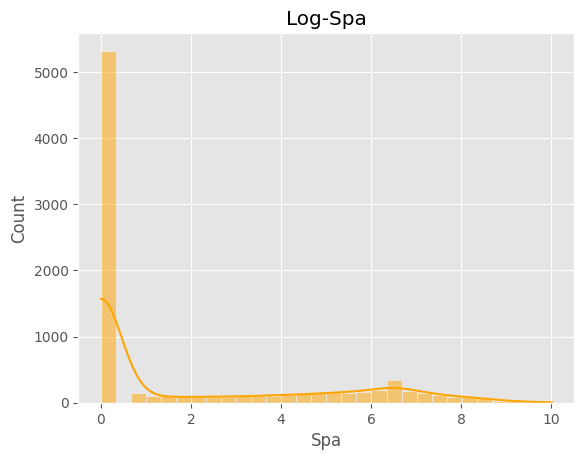

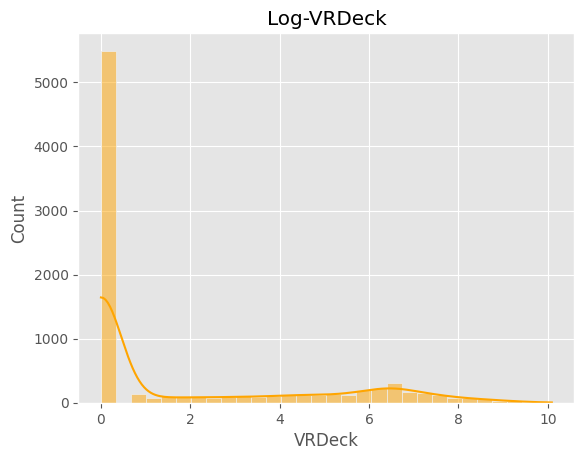

In [12]:
for c in ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']:
    sns.histplot(np.log1p(train_df[c]), bins=30, kde=True, color="orange"); plt.title(f"Log-{c}"); plt.show()


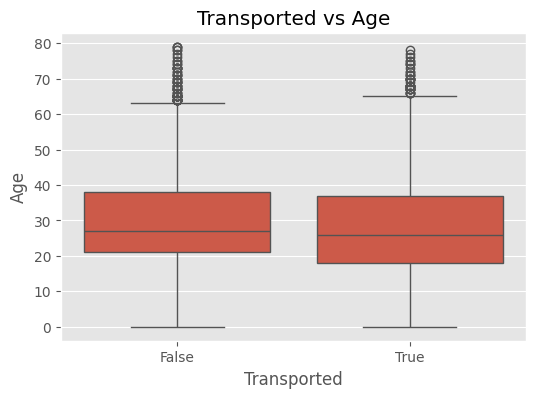

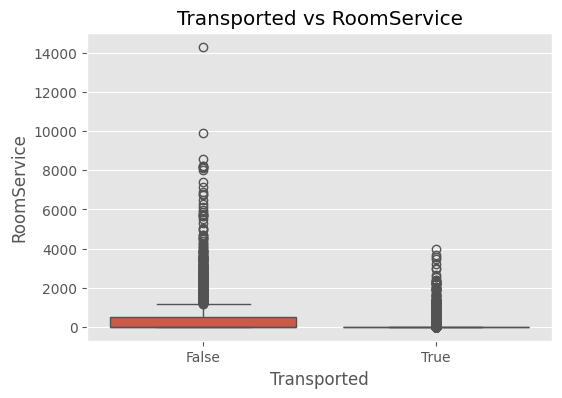

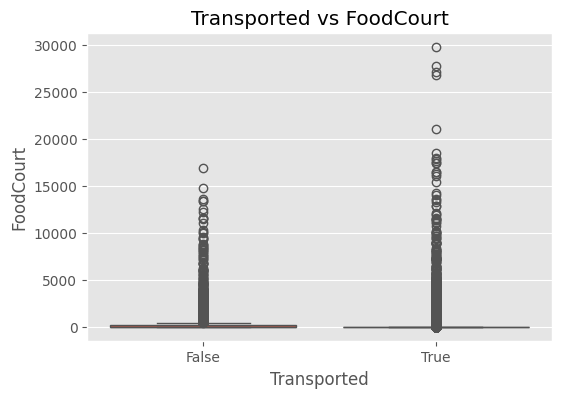

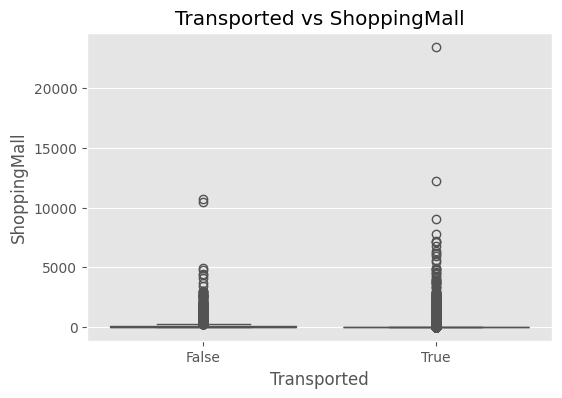

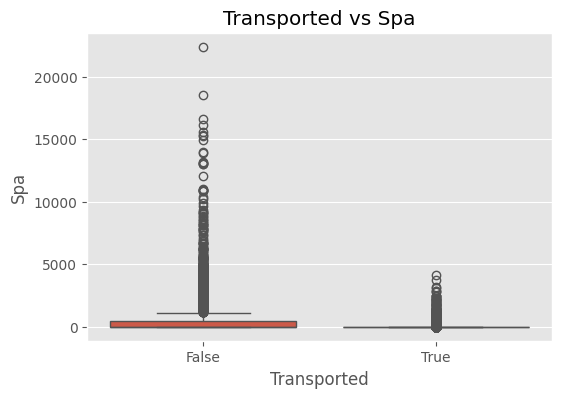

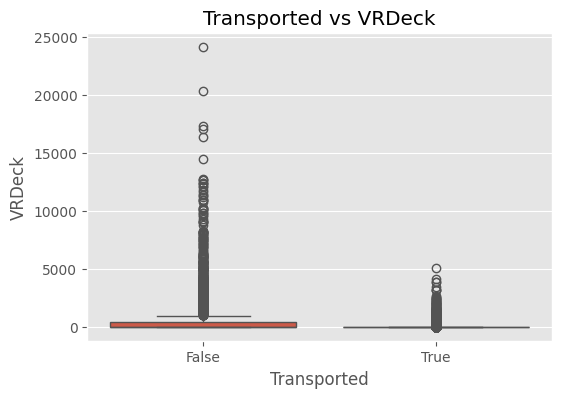

In [13]:
numeric_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Transported', y=col, data=train_df)
    plt.title(f"Transported vs {col}")
    plt.show()

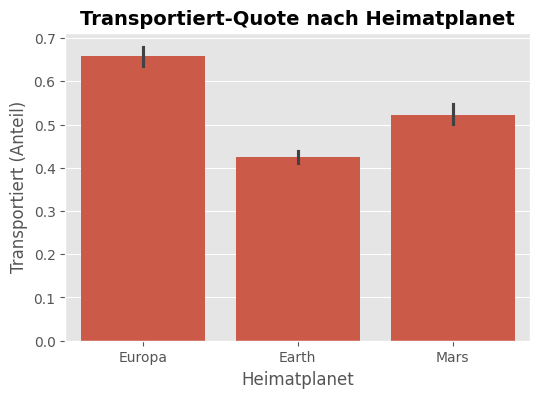

In [14]:
# Verteilung der kategorialen Variablen in Bezug auf das Ziel
plt.figure(figsize=(6,4))
sns.barplot(x='HomePlanet', y='Transported', data=train_df)
plt.title("Transportiert-Quote nach Heimatplanet", fontsize=14, fontweight='bold')
plt.xlabel("Heimatplanet")
plt.ylabel("Transportiert (Anteil)")
plt.show()

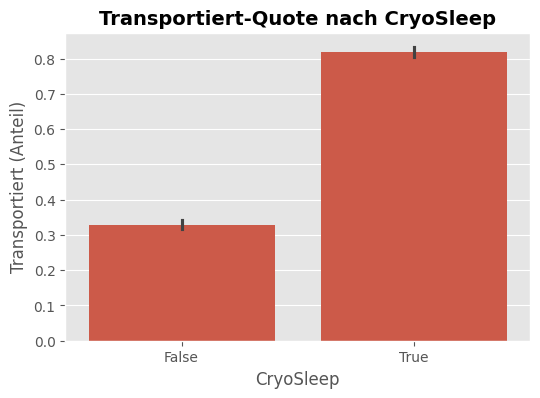

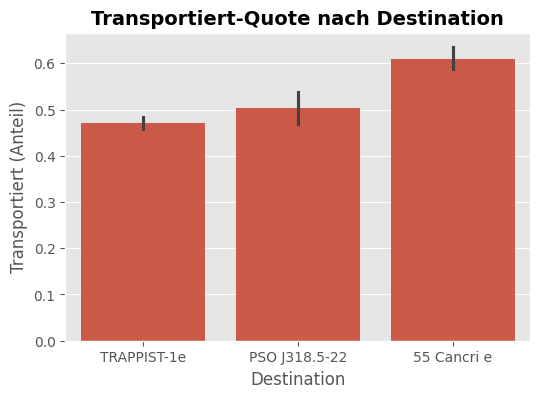

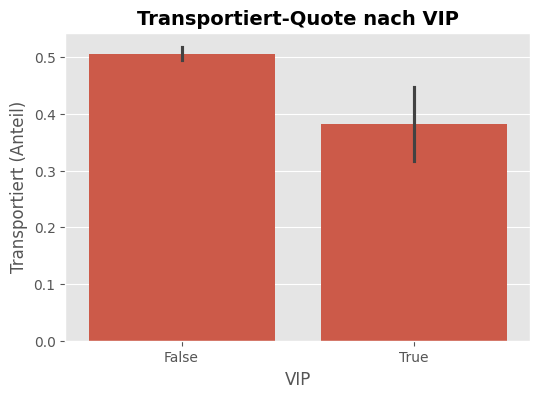

In [15]:
# Transportiert-Quote nach kategorialen Merkmalen
categorical_cols = ['CryoSleep', 'Destination', 'VIP']
for col in categorical_cols:
    plt.figure(figsize=(6,4))
    sns.barplot(x=col, y='Transported', data=train_df)
    plt.title(f"Transportiert-Quote nach {col}", fontsize=14, fontweight='bold')
    plt.xlabel(col)
    plt.ylabel("Transportiert (Anteil)")
    plt.show()

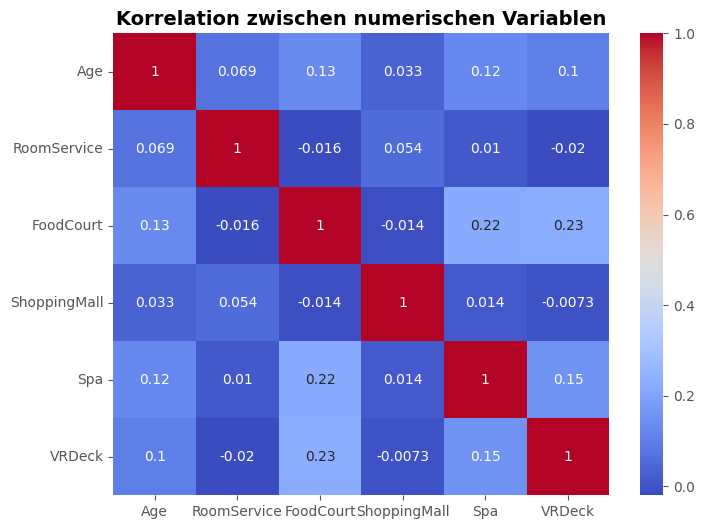

In [16]:
# Korrelation zwischen numerischen Variablen
plt.figure(figsize=(8,6))
sns.heatmap(train_df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Korrelation zwischen numerischen Variablen", fontsize=14, fontweight='bold')
plt.show()


### Feature Engineering

In [17]:
# Cabin in Deck, CabinNum und Side aufteilen (mit Füllwerten)
for df in [train_df, test_df]:
    c = df['Cabin'].fillna('Unknown/-1/Unknown').str.split('/', expand=True)
    df['Deck'] = c[0].str.strip()
    df['CabinNum'] = pd.to_numeric(c[1].str.strip(), errors='coerce')
    df['Side'] = c[2].str.strip()


In [18]:
#Passenger‑Group Features

In [19]:
for d in [train_df, test_df]:
    d['GroupId'] = d.PassengerId.str.split('_').str[0]
    d['GroupSize'] = d.GroupId.map(d.GroupId.value_counts())
    d['IsAlone'] = (d.GroupSize == 1).astype(int)


In [20]:
#Spending Features

In [21]:
spend_cols = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
for d in (train_df, test_df):
    d['TotalSpend'] = d[spend_cols].sum(axis=1)
    d['HasSpend'] = (d.TotalSpend > 0).astype(int)
    for c in spend_cols + ['TotalSpend']:
        d[c+'_log1p'] = np.log1p(d[c].clip(lower=0))


In [22]:
# Cryo‑Sleep Konsistenz

In [23]:
for d in (train_df, test_df):
    d['SpendWhileCryo'] = ((d['CryoSleep'] == True) & (d['TotalSpend'] > 0)).astype(int)


In [24]:
#Einfache, sinnvolle Imputation

In [25]:

# Kategorische Defaults
for col in ['HomePlanet','Destination','Deck','Side']:
    for d in (train_df, test_df):
        d[col] = d[col].fillna('Unknown')

# Numerisch per Median (robust bei Schiefe)
num_cols = ['Age','CabinNum'] + spend_cols + [c+'_log1p' for c in spend_cols+['TotalSpend']]
for d in (train_df, test_df):
    d[num_cols] = pd.DataFrame(SimpleImputer(strategy='median').fit(train_df[num_cols]).transform(d[num_cols]),
                               columns=num_cols, index=d.index)


In [26]:
# Age‑Buckets

In [27]:
bins = [-1, 12, 18, 35, 55, 120]
labels = ['Kind','Teen','Erwachsen','Mitte','Senior']
for d in (train_df, test_df):
    d['AgeBin'] = pd.cut(d['Age'], bins=bins, labels=labels)


In [28]:
#(Optional) CV‑Target‑Encoding (leakage‑frei)

In [29]:
# !pip install category_encoders

In [30]:



cat_cols = ['HomePlanet','Destination','Deck','Side','AgeBin']
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_df['Transported'] = train_df['Transported'].astype(int)

oof = pd.Series(index=train_df.index, dtype=float)
for tr_idx, va_idx in skf.split(train_df, train_df['Transported']):
    enc = ce.TargetEncoder(cols=cat_cols)
    enc.fit(train_df.loc[tr_idx, cat_cols], train_df.loc[tr_idx, 'Transported'])
    oof.iloc[va_idx] = enc.transform(train_df.loc[va_idx, cat_cols]).sum(axis=1)

# Fit final encoder on full train und transform test
final_enc = ce.TargetEncoder(cols=cat_cols).fit(train_df[cat_cols], train_df['Transported'])
train_te = final_enc.transform(train_df[cat_cols])
test_te  = final_enc.transform(test_df[cat_cols])


In [31]:
#Minimal‑Pipeline

In [32]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Features
cat = ['HomePlanet','Destination','Deck','Side','AgeBin','CryoSleep','VIP']
num = ['Age','CabinNum','TotalSpend'] + [c+'_log1p' for c in spend_cols+['TotalSpend']] + ['GroupSize','IsAlone','SpendWhileCryo']

In [33]:
# - OneHotEncoder für Kategorische
# - Numerische werden unverändert durchgelassen (passthrough)
pre = ColumnTransformer([('cat', OneHotEncoder(handle_unknown='ignore'), cat),
                         ('num', 'passthrough', num)])

# RandomForestClassifier:
# - 600 Bäume
# - Nutzung aller Kerne (n_jobs=-1)
# - Reproduzierbarkeit via random_state

pipe = Pipeline([('pre', pre),
                 ('clf', RandomForestClassifier(n_estimators=600, n_jobs=-1, random_state=42))])

#Cross-Validation & Scores
X, y = train_df[cat+num], train_df['Transported'].astype(int)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [34]:
# Durchschnittliche Genauigkeit + Streuung
scores = cross_val_score(pipe, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
print(f"CV-Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

CV-Accuracy: 0.8025 ± 0.0096



Klassifikationsbericht (OOF):
               precision    recall  f1-score   support

           0      0.780     0.838     0.808      4315
           1      0.828     0.767     0.796      4378

    accuracy                          0.802      8693
   macro avg      0.804     0.803     0.802      8693
weighted avg      0.804     0.802     0.802      8693



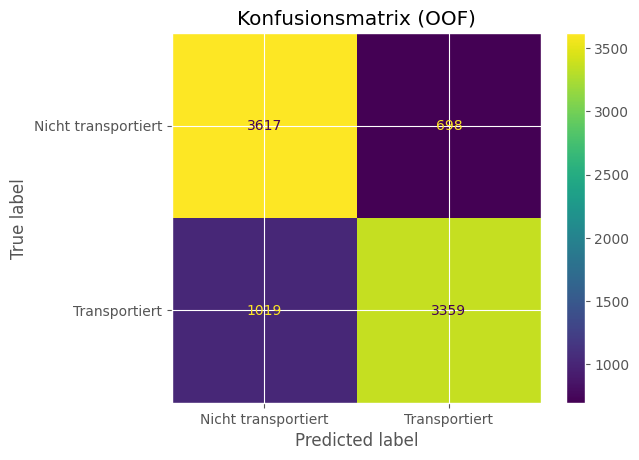

In [35]:
# OOF-Preds für Confusion Matrix (leakage-frei)
oof_pred = cross_val_predict(pipe, X, y, cv=cv, n_jobs=-1)

# Konfusionsmatrix visualisieren
cm = confusion_matrix(y, oof_pred, labels=[0,1])
print("\nKlassifikationsbericht (OOF):\n", classification_report(y, oof_pred, digits=3))
ConfusionMatrixDisplay(cm, display_labels=['Nicht transportiert','Transportiert']).plot(values_format='d')
plt.title("Konfusionsmatrix (OOF)")
plt.show()

In [36]:
# 3) Final fit + Submission
pipe.fit(X, y)
test_pred = pipe.predict(test_df[cat+num]).astype(bool)
submission = test_df[['PassengerId']].copy()
submission['Transported'] = test_pred
submission.to_csv('submission.csv', index=False)
print("\n submission.csv gespeichert.")


 submission.csv gespeichert.
